Setup

In [183]:
%pip install -r requirements.txt -q --disable-pip-version-check

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

Note: you may need to restart the kernel to use updated packages.


GRAPH REPRESENTATION

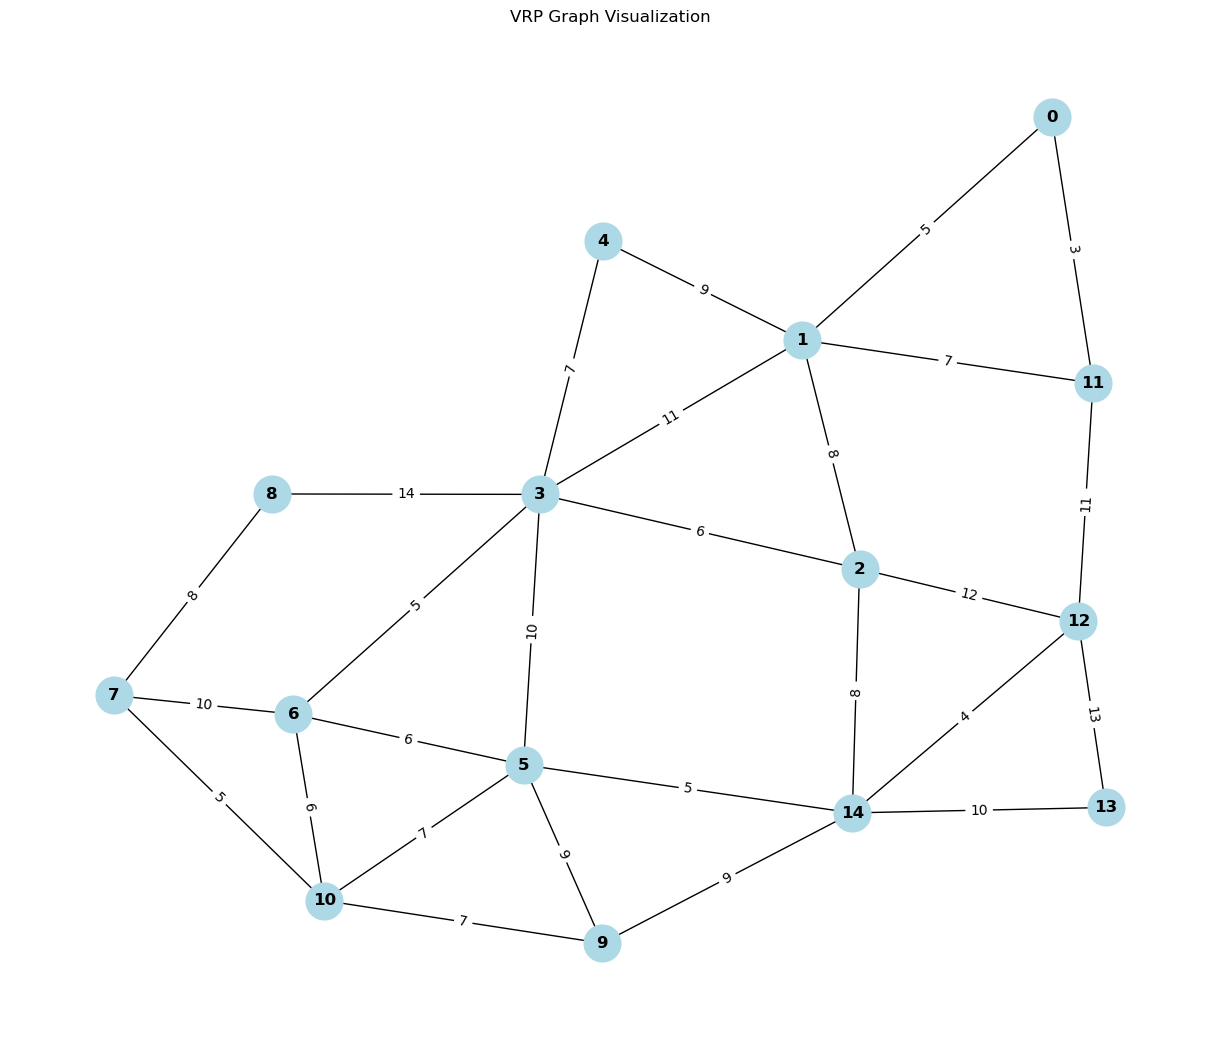

In [184]:
POPULATION_SIZE = 1000
ELITE_COUNT = 10
MAX_GENERATION = 500
TOURNAMENT_SIZE = 5

TOTAL_CUSTOMER = 15
VEHICLE_CAPACITY = 30
MUTATION_RATE = 0.2

edge_list = [
    (0, 1, 5), (0, 11, 3),
    (1, 2, 8), (1, 3, 11), (1, 4, 9), (1, 11, 7),
    (2, 3, 6), (2, 12, 12), (2, 14, 8),
    (3, 4, 7), (3, 5, 10), (3, 6, 5), (3, 8, 14),
    (5, 6, 6), (5, 9, 9), (5, 10, 7), (5, 14, 5),
    (6, 7, 10), (6, 10, 6),
    (7, 8, 8), (7, 10, 5),
    (9, 10, 7), (9, 14, 9),
    (11, 12, 11),
    (12, 13, 13), (12, 14, 4),
    (13, 14, 10)
]

customer_demand = [0, 2, 10, 5, 14, 3, 8, 20, 4, 6, 1, 13, 8, 16, 3]

G = nx.Graph()
G.add_nodes_from(range(TOTAL_CUSTOMER))
G.add_weighted_edges_from(edge_list)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='lightblue',
    font_weight='bold',
    node_size=700
)

edge_labels = nx.get_edge_attributes(G, 'weight')

nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=edge_labels
)

plt.title("VRP Graph Visualization")
plt.show()


DISTANCE MATRIX

In [185]:
# dist mat with fw
dist_matrix_fw = nx.floyd_warshall_numpy(G, weight='weight')

# dist mat with 
dist_matrix_dj = np.zeros((TOTAL_CUSTOMER, TOTAL_CUSTOMER))
for i in range(TOTAL_CUSTOMER):
    for j in range(TOTAL_CUSTOMER):
        if i == j:
            dist_matrix_dj[i][j] = 0
        else:
            dist_matrix_dj[i][j] = nx.shortest_path_length(G, i, j, weight='weight')

dist_df = pd.DataFrame(
    dist_matrix_fw,
    index=[f"Node {i}" for i in range(TOTAL_CUSTOMER)],
    columns=[f"Node {i}" for i in range(TOTAL_CUSTOMER)]
)

print("DISTANCE MATRIX")
dist_df

DISTANCE MATRIX


,Node 0,Node 1,Node 2,Node 3,Node 4,Node 5,Node 6,Node 7,Node 8,Node 9,Node 10,Node 11,Node 12,Node 13,Node 14
Node 0,0.0,5.0,13.0,16.0,14.0,23.0,21.0,31.0,30.0,27.0,27.0,3.0,14.0,27.0,18.0
Node 1,5.0,0.0,8.0,11.0,9.0,21.0,16.0,26.0,25.0,25.0,22.0,7.0,18.0,26.0,16.0
Node 2,13.0,8.0,0.0,6.0,13.0,13.0,11.0,21.0,20.0,17.0,17.0,15.0,12.0,18.0,8.0
Node 3,16.0,11.0,6.0,0.0,7.0,10.0,5.0,15.0,14.0,18.0,11.0,18.0,18.0,24.0,14.0
Node 4,14.0,9.0,13.0,7.0,0.0,17.0,12.0,22.0,21.0,25.0,18.0,16.0,25.0,31.0,21.0
Node 5,23.0,21.0,13.0,10.0,17.0,0.0,6.0,12.0,20.0,9.0,7.0,20.0,9.0,15.0,5.0
Node 6,21.0,16.0,11.0,5.0,12.0,6.0,0.0,10.0,18.0,13.0,6.0,23.0,15.0,21.0,11.0
Node 7,31.0,26.0,21.0,15.0,22.0,12.0,10.0,0.0,8.0,12.0,5.0,32.0,21.0,27.0,17.0
Node 8,30.0,25.0,20.0,14.0,21.0,20.0,18.0,8.0,0.0,20.0,13.0,32.0,29.0,35.0,25.0
Node 9,27.0,25.0,17.0,18.0,25.0,9.0,13.0,12.0,20.0,0.0,7.0,24.0,13.0,19.0,9.0


GA HELPER FUNCTION

In [186]:
def generate_chrom():
    chrom = list(range(1, TOTAL_CUSTOMER))
    random.shuffle(chrom)
    return chrom


def generate_population(total_population: int):
    pop = []
    for i in range(total_population):
        pop.append(generate_chrom())
    return pop


def decode_chrom(chrom: list):
    routes = []
    current_route = [0]
    current_load = 0
    chrom_copy = chrom.copy()

    while len(chrom_copy):
        current_load += customer_demand[chrom_copy[0]]
        if current_load <= VEHICLE_CAPACITY:
            current_route.append(chrom_copy.pop(0))
        else:
            current_load -= customer_demand[chrom_copy[0]]
            current_route.append(0)
            routes.append(current_route)
            current_route = [0]
            current_load = 0
        
    current_route.append(0)
    routes.append(current_route)

    total_dist = 0
    for route in routes:
        for a, b in zip(route, route[1:]):
            total_dist += dist_matrix_fw[a][b]

    return routes, total_dist


def calculate_fitness(chrom: list):
    routes, total_dist = decode_chrom(chrom)
    if len(routes) > 4:
        return 0
    if total_dist == 0:
        return 0
    return 1 / total_dist


def tournament_selection(population, tournament_size=TOURNAMENT_SIZE):
    contestant = random.sample(population, tournament_size)
    winner = max(contestant, key=calculate_fitness)
    return winner


def get_elite(population, elite_count=ELITE_COUNT):
    population_with_fitness_value = []

    for i in range(len(population)):
        fitness_value = calculate_fitness(population[i])
        population_with_fitness_value.append((population[i], fitness_value))
        
    population_with_fitness_value.sort(key=lambda x: x[1], reverse=True)
    return [chrom for chrom, fitness in population_with_fitness_value[:elite_count]]

def _build_aex_lookup(chrom: list):
    lookup_map = {}

    for i in range(TOTAL_CUSTOMER-1):
        current_customer = chrom[i]

        if i == TOTAL_CUSTOMER - 2:
            next_customer = chrom[0]
        else:
            next_customer = chrom[i+1]
        
        lookup_map[current_customer] = next_customer
    
    return lookup_map


def aex_crossover(parent_1: list, parent_2: list):
    p1_map = _build_aex_lookup(parent_1)
    p2_map = _build_aex_lookup(parent_2)

    child = [None] * (TOTAL_CUSTOMER-1)
    visited = set()

    current_customer = parent_1[0]

    child[0] = current_customer
    visited.add(current_customer)

    current_parent_map = p2_map

    for i in range(1, TOTAL_CUSTOMER-1):
        next_customer = current_parent_map[current_customer]

        if next_customer in visited:
            all_nodes = set(parent_1)
            unvisited_customer = list(all_nodes - visited)

            if not unvisited_customer:
                break

            next_customer = random.choice(unvisited_customer)

        child[i] = next_customer
        visited.add(next_customer)
        current_customer = next_customer

        if current_parent_map == p1_map:
            current_parent_map = p2_map
        else:
            current_parent_map = p1_map

    return child


def inverse_mutation(chrom: list):
    if random.random() < MUTATION_RATE:
        mutated_chrom = chrom.copy()
        point1 = random.randint(0, len(mutated_chrom)-1)
        point2 = random.randint(0, len(mutated_chrom)-1)

        if point1 > point2:
            point1, point2 = point2, point1
        
        mutated_chrom[point1:point2+1] = reversed(mutated_chrom[point1:point2+1])
        return mutated_chrom
    else:
        return chrom

VISUALIZATION FUNCTION

In [ ]:
def plot_convergence(fitness_history: list, distance_history: list):
    """Enhanced single plot with fitness and distance tracking"""
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
    
    generations = range(len(fitness_history))
    
    # ========== Fitness over time ==========
    ax_fitness = fig.add_subplot(gs[:, 0])
    ax_fitness.plot(generations, fitness_history, linewidth=2.5, 
                    color='darkblue', label='Best Fitness', 
                    marker='o', markersize=2, 
                    markevery=max(1, len(fitness_history)//50))
    
    # add trend line
    if len(fitness_history) > 10:
        window = min(50, len(fitness_history) // 10)
        smoothed = pd.Series(fitness_history).rolling(window=window, center=True).mean()
        ax_fitness.plot(generations, smoothed, linewidth=3, color='red', 
                       linestyle='--', alpha=0.7, label=f'Trend (MA-{window})')
    
    # mark key points
    ax_fitness.scatter([0], [fitness_history[0]], color='green', s=150, 
                      zorder=5, marker='^', label='Start', 
                      edgecolors='black', linewidths=2)
    ax_fitness.scatter([len(fitness_history)-1], [fitness_history[-1]], 
                      color='red', s=150, zorder=5, marker='v', 
                      label='End', edgecolors='black', linewidths=2)
    
    best_idx = fitness_history.index(max(fitness_history))
    ax_fitness.scatter([best_idx], [fitness_history[best_idx]], 
                      color='gold', s=200, zorder=5, marker='*', 
                      label='Best', edgecolors='black', linewidths=2)
    
    # impromvent anot
    improvement = ((fitness_history[-1] - fitness_history[0]) / fitness_history[0] * 100)
    ax_fitness.text(0.5, 0.95, f'Improvement: {improvement:.2f}%', 
                   transform=ax_fitness.transAxes, fontsize=12, 
                   verticalalignment='top', horizontalalignment='center',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax_fitness.set_xlabel('Generation', fontsize=13, fontweight='bold')
    ax_fitness.set_ylabel('Fitness Value (1/Distance)', fontsize=13, fontweight='bold')
    ax_fitness.set_title('Fitness Evolution', fontsize=15, fontweight='bold')
    ax_fitness.grid(True, alpha=0.3, linestyle='--')
    ax_fitness.legend(loc='lower right', fontsize=10)
    
    # ========== DISTANCE PLOT ==========
    ax_distance = fig.add_subplot(gs[0, 1])
    ax_distance.plot(generations, distance_history, linewidth=2.5, 
                    color='crimson', label='Total Distance')
    ax_distance.fill_between(generations, distance_history, 
                            alpha=0.3, color='crimson')
    
    # mark best distance
    best_dist_idx = distance_history.index(min(distance_history))
    ax_distance.scatter([best_dist_idx], [distance_history[best_dist_idx]], 
                       color='gold', s=200, zorder=5, marker='*', 
                       edgecolors='black', linewidths=2, label='Best')
    
    dist_improvement = ((distance_history[0] - distance_history[-1]) / distance_history[0] * 100)
    ax_distance.text(0.5, 0.5, 
                    f'Distance Reduced: {dist_improvement:.2f}%\n' +
                    f'From {distance_history[0]:.2f} to {distance_history[-1]:.2f}',
                    transform=ax_distance.transAxes, fontsize=9, 
                    verticalalignment='center', horizontalalignment='center',
                    bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    ax_distance.set_xlabel('Generation', fontsize=12, fontweight='bold')
    ax_distance.set_ylabel('Total Distance', fontsize=12, fontweight='bold')
    ax_distance.set_title('Distance Minimization', fontsize=14, fontweight='bold')
    ax_distance.grid(True, alpha=0.3, linestyle='--')
    ax_distance.legend(loc='upper right')
    
    # ========== STATISTICS BOX ==========
    ax_stats = fig.add_subplot(gs[0, 2])
    ax_stats.axis('off')
    
    stagnant = sum(1 for i in range(1, len(fitness_history)) 
                   if fitness_history[i] == fitness_history[i-1])
    
    stats_text = f"""
    PERFORMANCE METRICS

    Initial Fitness: {fitness_history[0]:.6f}
    Best Fitness: {max(fitness_history):.6f}
    Final Fitness: {fitness_history[-1]:.6f}
    Improvement: {improvement:.2f}%

    Initial Distance: {distance_history[0]:.2f}
    Best Distance: {min(distance_history):.2f}
    Final Distance: {distance_history[-1]:.2f}
    Reduction: {dist_improvement:.2f}%

    Total Generations: {len(fitness_history)}
    Best Found at Gen: {best_idx}
    Stagnant Gens: {stagnant} ({stagnant/len(fitness_history)*100:.1f}%)
    """
    
    ax_stats.text(0.05, 0.98, stats_text, fontsize=9, 
                 verticalalignment='top', horizontalalignment='left',
                 family='monospace',
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.9))
    
    # ========== IMPROVEMENT RATE PLOT ==========
    ax_improve = fig.add_subplot(gs[1:, 1:])
    
    improvements = [fitness_history[i] - fitness_history[i-1] 
                   for i in range(1, len(fitness_history))]
    
    colors_improve = ['green' if x > 0 else 'lightgray' for x in improvements]
    ax_improve.bar(range(len(improvements)), improvements, 
                  color=colors_improve, alpha=0.7, edgecolor='black', linewidth=0.5)
    ax_improve.axhline(y=0, color='red', linestyle='-', linewidth=1.5)
    
    positive_improvements = sum(1 for x in improvements if x > 0)
    ax_improve.text(0.5, 0.95, 
                   f'Improvements: {positive_improvements}/{len(improvements)} ' +
                   f'({positive_improvements/len(improvements)*100:.1f}%)',
                   transform=ax_improve.transAxes, fontsize=10,
                   verticalalignment='top', horizontalalignment='center',
                   bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    
    ax_improve.set_xlabel('Generation', fontsize=11, fontweight='bold')
    ax_improve.set_ylabel('Fitness Change', fontsize=11, fontweight='bold')
    ax_improve.set_title('Fitness Improvement per Generation', fontsize=12, fontweight='bold')
    ax_improve.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Genetic Algorithm Convergence Analysis', 
                fontsize=17, fontweight='bold', y=0.99)
    
    plt.show()
    
    # detailed statistics
    print("\n" + "="*70)
    print("CONVERGENCE STATISTICS")
    print("="*70)
    print(f"{'Metric':<30} {'Initial':<15} {'Best':<15} {'Final':<15}")
    print("-"*70)
    print(f"{'Fitness':<30} {fitness_history[0]:<15.6f} {max(fitness_history):<15.6f} {fitness_history[-1]:<15.6f}")
    print(f"{'Distance':<30} {distance_history[0]:<15.2f} {min(distance_history):<15.2f} {distance_history[-1]:<15.2f}")
    print("-"*70)
    print(f"{'Fitness Improvement:':<30} {improvement:>15.2f}%")
    print(f"{'Distance Reduction:':<30} {dist_improvement:>15.2f}%")
    print(f"{'Best Found at Generation:':<30} {best_idx:>15}")
    print(f"{'Stagnant Generations:':<30} {stagnant:>15} ({stagnant/len(fitness_history)*100:.1f}%)")
    print(f"{'Positive Improvements:':<30} {positive_improvements:>15} ({positive_improvements/len(improvements)*100:.1f}%)")
    print("="*70 + "\n")

def print_solution(chrom: list):
    routes, total_dist = decode_chrom(chrom)

    print("\n" + "="*50)
    print("BEST SOLUTION FOUND")
    print("="*50)
    print(f"Total Distance: {total_dist:.2f}")
    print(f"Number of Routes: {len(routes)}")
    print(f"Fitness: {calculate_fitness(chrom):.6f}")
    print("\nRoutes:")
    for i, route in enumerate(routes, 1):
        print(f"  Route {i}: {' → '.join(map(str, route))}")
    print("="*50)

def visualize_routes(chrom: list, G, pos=pos):
    routes, total_dist = decode_chrom(chrom)

    plt.figure(figsize=(10, 6))

    colors = ['red', 'blue', 'green', 'purple']

    nx.draw_networkx_nodes(G, pos, node_color='gray',
                           node_size=700, alpha=0.3)
    nx.draw_networkx_edges(G, pos, edge_color='gray',
                           width=1, alpha=0.3)
    
    for route_idx, route in enumerate(routes):
        color = colors[route_idx % len(colors)]

        route_edges = [(route[i], route[i+1]) for i in range(len(route)-1)]
        nx.draw_networkx_edges(G, pos, edgelist=route_edges,
                               edge_color=color, width=3,
                               alpha=0.8, arrows=True,
                               arrowsize=20, arrowstyle='->')
        route_nodes = [node for node in route if node != 0]
        nx.draw_networkx_nodes(G, pos, nodelist=route_nodes,
                               node_color=color, node_size=700)
        
    nx.draw_networkx_nodes(G, pos, nodelist=[0], 
                          node_color='yellow', node_size=1000, 
                          node_shape='s', edgecolors='black', linewidths=3)
    
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')


    legend_elements = [plt.Line2D([0], [0], color=colors[i], lw=3, 
                                  label=f'Route {i+1}') 
                      for i in range(len(routes))]
    legend_elements.append(plt.Line2D([0], [0], marker='s', color='w', 
                                     markerfacecolor='yellow', markersize=10,
                                     markeredgecolor='black', markeredgewidth=2,
                                     label='Depot', linestyle='None'))
    plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

    plt.title(f"VRP Solution Visualization\n"
             f"Total Distance: {total_dist:.2f} | Routes: {len(routes)} | "
             f"Fitness: {calculate_fitness(chrom):.6f}", 
             fontsize=14, fontweight='bold')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("ROUTE DETAILS")
    print("="*60)
    for i, route in enumerate(routes, 1):
        route_load = sum(customer_demand[node] for node in route if node != 0)
        route_dist = sum(dist_matrix_fw[route[j]][route[j+1]] 
                        for j in range(len(route)-1))
        print(f"Route {i}: {' → '.join(map(str, route))}")
        print(f"  Load: {route_load}/{VEHICLE_CAPACITY} | Distance: {route_dist:.2f}")
    print("="*60)

MAIN GENETIC ALGORITHM LOOP

In [188]:
def genetic_algorithm(pop_size: int, elite_count: int, max_gen: int, visualize_every: int):
    population = generate_population(pop_size)

    best_chrom = None
    best_fitness = 0
    fitness_history = []
    total_distance_history = []
    snapshots = []

    for generation in range(max_gen):
        elite = get_elite(population, elite_count)
        elite_fitness = [calculate_fitness(chrom) for chrom in elite]
        current_best_fitness = max(elite_fitness)

        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_chrom = elite[0].copy()

        fitness_history.append(best_fitness)

        _, distance = decode_chrom(best_chrom)
        total_distance_history.append(distance)

        if generation % 50 == 0:
            print(f"Generation {generation}: Best Fitness = {best_fitness:.6f}")

        if generation % visualize_every == 0:
            snapshots.append({
                'generation': generation,
                'chromosome': best_chrom.copy(),
                'fitness': best_fitness,
                'total-distance': distance
            })
            visualize_routes(best_chrom, G, pos)

        new_population = elite.copy()

        while len(new_population) < pop_size:
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)

            child = aex_crossover(parent1, parent2)
            child = inverse_mutation(child)

            new_population.append(child)
        
        population = new_population
    
    return best_chrom, best_fitness, fitness_history, total_distance_history, snapshots

RESULTS

STARTING GENETIC ALGORITHM
Generation 0: Best Fitness = 0.003774


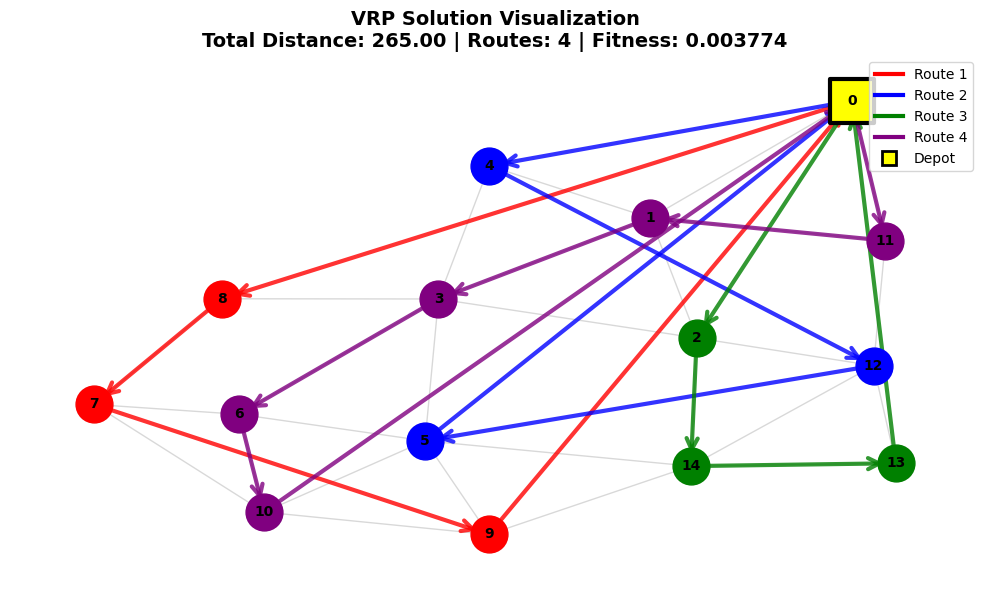


ROUTE DETAILS
Route 1: 0 → 8 → 7 → 9 → 0
  Load: 30/30 | Distance: 77.00
Route 2: 0 → 4 → 12 → 5 → 0
  Load: 25/30 | Distance: 71.00
Route 3: 0 → 2 → 14 → 13 → 0
  Load: 29/30 | Distance: 58.00
Route 4: 0 → 11 → 1 → 3 → 6 → 10 → 0
  Load: 29/30 | Distance: 59.00
Generation 50: Best Fitness = 0.004329
Generation 50: Best Fitness = 0.004329
Generation 100: Best Fitness = 0.004464
Generation 100: Best Fitness = 0.004464
Generation 150: Best Fitness = 0.004464
Generation 150: Best Fitness = 0.004464
Generation 200: Best Fitness = 0.004484
Generation 200: Best Fitness = 0.004484


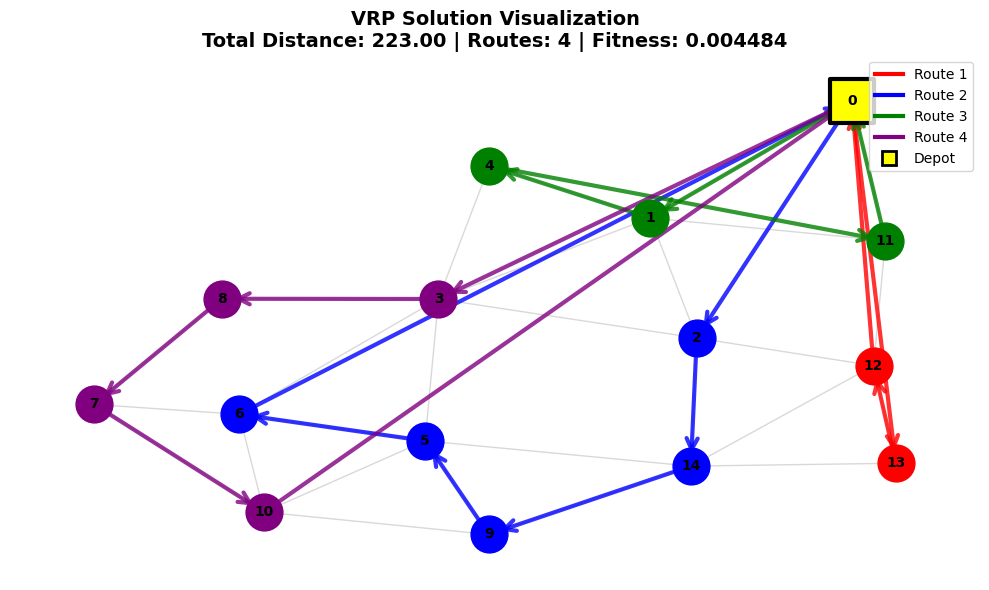


ROUTE DETAILS
Route 1: 0 → 13 → 12 → 0
  Load: 24/30 | Distance: 54.00
Route 2: 0 → 2 → 14 → 9 → 5 → 6 → 0
  Load: 30/30 | Distance: 66.00
Route 3: 0 → 1 → 4 → 11 → 0
  Load: 29/30 | Distance: 33.00
Route 4: 0 → 3 → 8 → 7 → 10 → 0
  Load: 30/30 | Distance: 70.00
Generation 250: Best Fitness = 0.004484
Generation 250: Best Fitness = 0.004484
Generation 300: Best Fitness = 0.004484
Generation 300: Best Fitness = 0.004484
Generation 350: Best Fitness = 0.004484
Generation 350: Best Fitness = 0.004484
Generation 400: Best Fitness = 0.004484
Generation 400: Best Fitness = 0.004484


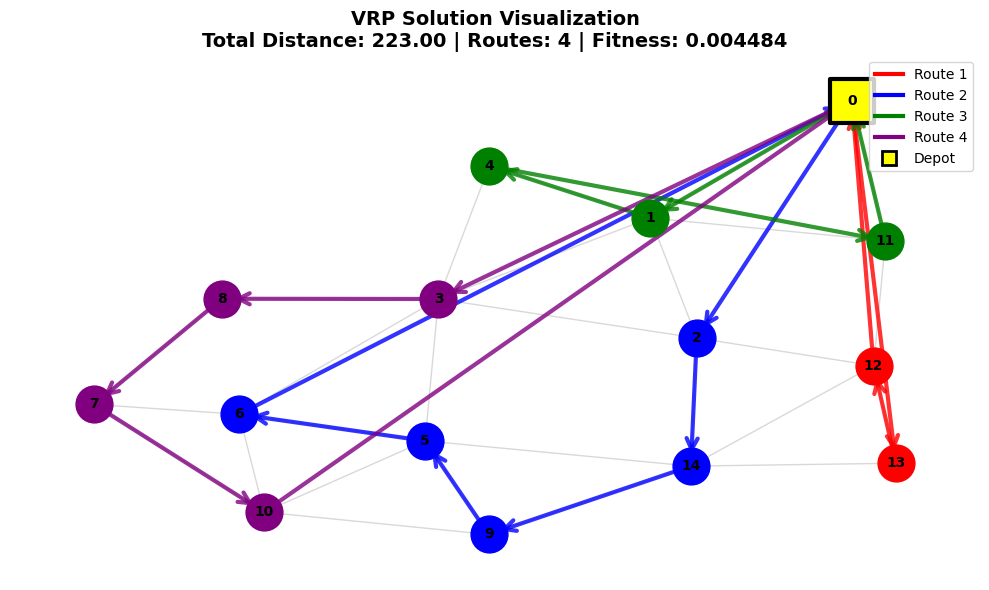


ROUTE DETAILS
Route 1: 0 → 13 → 12 → 0
  Load: 24/30 | Distance: 54.00
Route 2: 0 → 2 → 14 → 9 → 5 → 6 → 0
  Load: 30/30 | Distance: 66.00
Route 3: 0 → 1 → 4 → 11 → 0
  Load: 29/30 | Distance: 33.00
Route 4: 0 → 3 → 8 → 7 → 10 → 0
  Load: 30/30 | Distance: 70.00
Generation 450: Best Fitness = 0.004484
Generation 450: Best Fitness = 0.004484

REACHED MAX GEN

BEST SOLUTION FOUND
Total Distance: 223.00
Number of Routes: 4
Fitness: 0.004484

Routes:
  Route 1: 0 → 13 → 12 → 0
  Route 2: 0 → 2 → 14 → 9 → 5 → 6 → 0
  Route 3: 0 → 1 → 4 → 11 → 0
  Route 4: 0 → 3 → 8 → 7 → 10 → 0

REACHED MAX GEN

BEST SOLUTION FOUND
Total Distance: 223.00
Number of Routes: 4
Fitness: 0.004484

Routes:
  Route 1: 0 → 13 → 12 → 0
  Route 2: 0 → 2 → 14 → 9 → 5 → 6 → 0
  Route 3: 0 → 1 → 4 → 11 → 0
  Route 4: 0 → 3 → 8 → 7 → 10 → 0


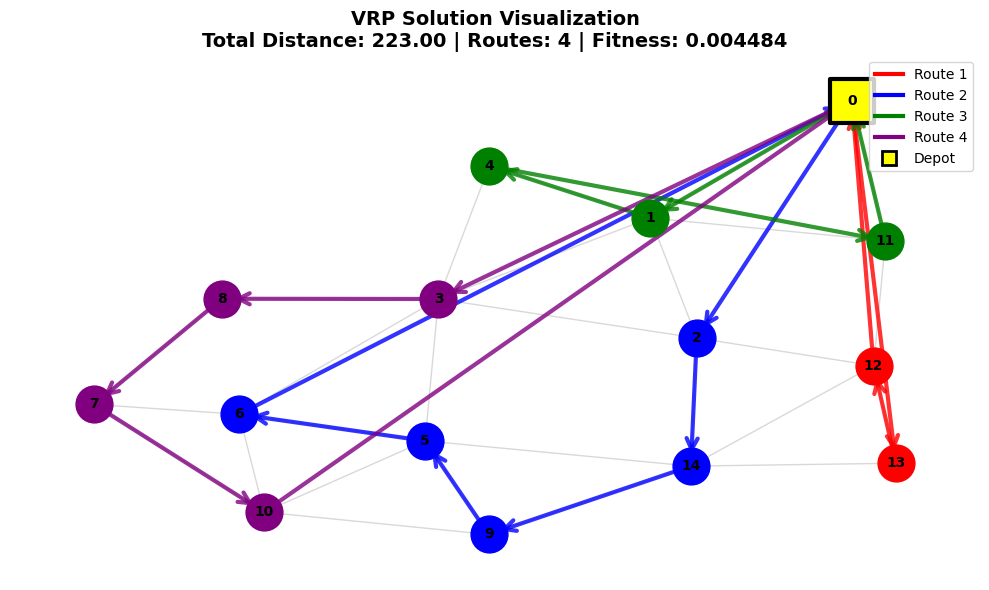


ROUTE DETAILS
Route 1: 0 → 13 → 12 → 0
  Load: 24/30 | Distance: 54.00
Route 2: 0 → 2 → 14 → 9 → 5 → 6 → 0
  Load: 30/30 | Distance: 66.00
Route 3: 0 → 1 → 4 → 11 → 0
  Load: 29/30 | Distance: 33.00
Route 4: 0 → 3 → 8 → 7 → 10 → 0
  Load: 30/30 | Distance: 70.00


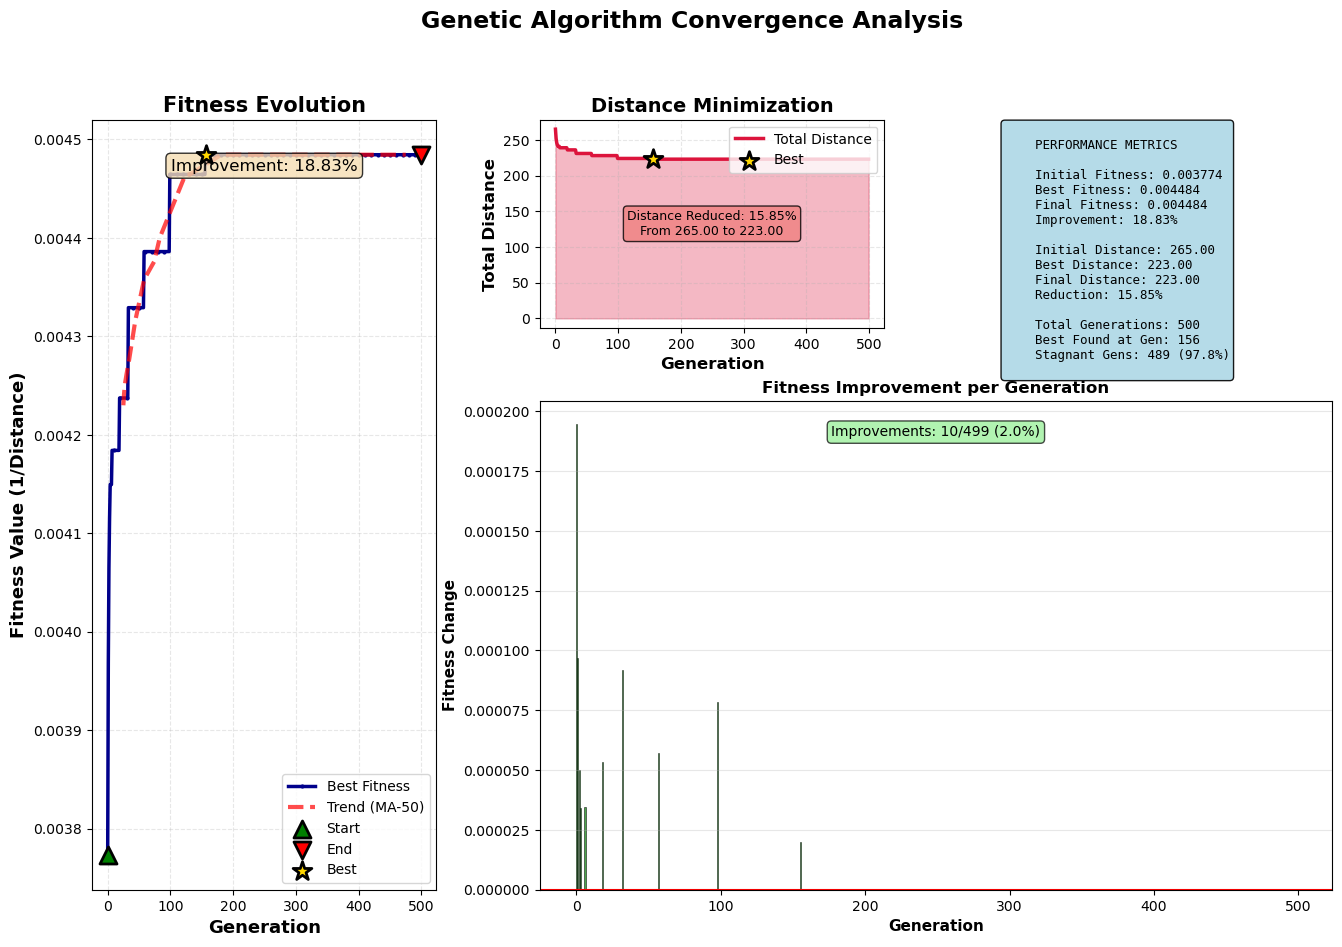


CONVERGENCE STATISTICS
Metric                         Initial         Best            Final          
----------------------------------------------------------------------
Fitness                        0.003774        0.004484        0.004484       
Distance                       265.00          223.00          223.00         
----------------------------------------------------------------------
Fitness Improvement:                     18.83%
Distance Reduction:                      15.85%
Best Found at Generation:                  156
Stagnant Generations:                      489 (97.8%)
Positive Improvements:                      10 (2.0%)



In [189]:
print("STARTING GENETIC ALGORITHM")
print("=" * 70)

best_chrom, best_fit, history, dist_history, snapshots = genetic_algorithm(
    pop_size=POPULATION_SIZE,
    elite_count=ELITE_COUNT,
    max_gen=MAX_GENERATION,
    visualize_every= 200
)

print("\n" + "=" * 70)
print("REACHED MAX GEN")
print("=" * 70)

print_solution(best_chrom)
visualize_routes(best_chrom, G, pos)
plot_convergence(history, dist_history)